In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### functions for easier usage

In [3]:
def intradayreps(csvname):
    #take intraday reports from csv
    dfname = pd.read_csv(csvname, header=1)
    
    #rename column for easier access
    dfname.rename(columns={'Date Time':'Date_Time'}, inplace=True)
    
    #drop last row original file includes where the file was 
    #downloaded from
    dfname.drop(dfname.tail(1).index, inplace=True)
    
    #split date time value into date and time columns
    dfname['Date'] = pd.to_datetime(dfname['Date_Time']).dt.date
    dfname['Time'] = pd.to_datetime(dfname['Date_Time']).dt.time
    
    #drop open interest value (since not useful) and date_time column
    dfname.drop(['Open Interest', 'Date_Time'], axis=1, inplace=True)
    
    #return resulting dataframe
    return dfname

In [4]:
def specificIntraday(df, date):
    #convert date column to string to compare
    df['Date'] = df['Date'].astype(str)
    
    #convert time column to string for plotting as x axis
    df['Time'] = df['Time'].astype(str)
    
    #return the dataframe with only values with the looked for date
    dfdate = df[df['Date'] == date]
    
    #return df with only specific date
    return dfdate

In [5]:
def plotintraday(intraday, xcolumn, ycolumn):
    #plot the intraday movement
    tclose = sns.lineplot(x=xcolumn, y=ycolumn, data=intraday)

    #label only a specific amount of ticks for better legibility
    tclose.xaxis.set_major_locator(ticker.MultipleLocator(5))

    #rotate tick labels for better legibility
    plt.xticks(rotation=45)

In [6]:
#function for rounding numbers to a specific base
def myround(x, base=5):
    return base * round(x/base)

In [7]:
#round to the fifth minute to match with intraday data
def timeround(testr):
    count=0
    for value in testr:
        #if seconds round up the minute
        if value.second >= 30:
            #add a minute
            minuteval = value.minute 
            minuteval += 1
            #if minute values round up the hour
            if minuteval >= 55:
                #add an hour
                hrval = value.hour
                hrval += 1
                #store timestamp; 
                #base 120 for minutes so it rounds to 0 
                #--> also store :00: in minutes
                testr.values[count] = \
                        pd.to_datetime(str(hrval) \
                        + ":0" +  \
                        str(myround(minuteval, base=120)) \
                        + ":" + \
                        str(myround(value.second, base=120)))
                count+=1
            #if minutes would round down 
            #(need 0 in front to properly store)
            elif minuteval < 8:
                #print the sentence as hh:0m:0s
                testr.values[count] = \
                    pd.to_datetime(str(value.hour) \
                    + ":0" +  \
                    str(myround(minuteval, base=5))\
                    + ":0" + \
                    str(myround(value.second, base=120)))
                count+=1
            #else minutes round normally
            else:
                testr.values[count] = \
                    pd.to_datetime(str(value.hour) \
                    + ":" +  \
                    str(myround(minuteval, base=5))\
                    + ":" + \
                    str(myround(value.second, base=120)))
                count+=1
        #if seconds are < 30 but minute would round up hour
        elif value.minute >= 55:
            #add hour value
            hrval = value.hour
            hrval += 1
            testr.values[count] = \
                pd.to_datetime(str(hrval) \
                + ":0" +  \
                str(myround(value.minute, base=120))\
                + ":" + \
                str(myround(value.second, base=120)))
            count+=1
        #if minutes are less than 8 (will round down to 5)
        elif value.minute < 8:
            #print the sentence as hh:0m:0s to proper store as timestamp
                testr.values[count] = \
                    pd.to_datetime(str(value.hour) \
                    + ":0" +  \
                    str(myround(value.minute, base=5))\
                    + ":0" +\
                    str(myround(value.second, base=120)))
                count+=1
        #the rounding of all time values does not affect another
        else:
            testr.values[count] = \
                    pd.to_datetime(str(value.hour) \
                    + ":" +  \
                    str(myround(value.minute, base=5))\
                    + ":" + \
                    str(myround(value.second, base=120)))
            count+=1
    return testr

In [8]:
def redditFile(csvname):
    #read data from reddit upvotes sheet
    dfname = pd.read_csv(csvname)
    
    #split date time into separate columns
    dfname['Day'] = pd.to_datetime(dfname['Date']).dt.date
    dfname['Time'] = pd.to_datetime(dfname['Date']).dt.time
    
    #save the time column
    dftime = dfname['Time']
    #round the time column
    dftime = timeround(dftime)
    #insert it into a new column in dataframe
    dfname['RoundedTime'] = dftime
    #replace Time column with the rounded times
    dfname['Time'] = pd.to_datetime(dfname['RoundedTime']).dt.time
    
    #drop the original date column and the newly created roundedtime
    dfname.drop(['Date', 'RoundedTime'], axis=1, inplace=True)
    #sort values by time values
    dfname.sort_values(by= 'Time', ascending = True, inplace=True)
    
    #rename upvotes column for easier access
    dfname.rename(columns={'UpVotes Ratio':'Upvotes', 'Day':'Date'},\
                  inplace=True)

    return dfname

In [9]:
def redditDay(dfname, compName, ticker, date):
    #change day values to string for comparison
    dfname['Date'] = dfname['Date'].astype(str)
    
    #convert time values to string for plotting
    dfname['Time'] = dfname['Time'].astype(str)
    
    #save only dataframe where the dates match
    dfdate = dfname[( (dfname['Stock'] == compName) | \
       (dfname['Stock'] == ticker) ) & \
       (dfname['Date'] == date)]
    
    return dfdate

In [10]:
def plotreddit(reddit, xcolumn, ycolumn):
    #plot the upvote movement with the time
    upv = sns.lineplot(x=xcolumn, y=ycolumn, data=reddit)

    #rotate xaxis labels for better legibility
    plt.xticks(rotation=45)

In [11]:
def merged(intrastock, reddit, column):
    #merge the intrastock and reddit dataframes
    merged = intrastock.merge(reddit, on=column)
    return merged

In [12]:
def plotboth(merged, date, plotopen=True):
    #declare lines that will be included in the subplot
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    #plot the intraday trend
    ax.plot(merged['Time'], merged['Close'], color="C0", label='Close')
    ax.set_xlabel("Time", color="C0")
    ax.set_ylabel("Close", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    #plot the upvote trend
    ax2.plot(merged['Time'], merged['Upvotes'], color="C1", label="Upvotes")
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Upvote Ratio', color="C1")       
    ax2.yaxis.set_label_position('right') 
    ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    #plot the open line to compare open to close -- true by default
    if plotopen:
        #add third line to subplot
        ax3=fig.add_subplot(111, label="3", frame_on=False)
        #plot the opening price for each minute to see the change of 
        #open to close for that time frame
        ax3.plot(merged['Time'], merged['Open'], color="C3", label='Open')
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_title('Intraday Close and Open to Upvotes on ' + str(date))
    else:
        ax.set_title('Intraday Close to Upvotes on ' + str(date))
    
    plt.legend()
    #rotate both x axis labels for better legibility
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

### feb 26, 2021

In [87]:
df = intradayreps('GME_Intraday2021.csv')

In [14]:
df26 = specificIntraday(df, '2021-02-26')

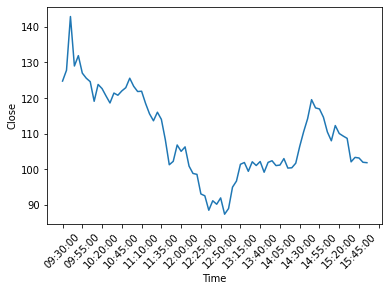

In [15]:
plotintraday(df26, 'Time', 'Close')

In [16]:
reddit = redditFile('RedditStocksDate2-26.csv')

In [17]:
r26 = redditDay(reddit, 'gamestop', 'gme', '2021-02-26')

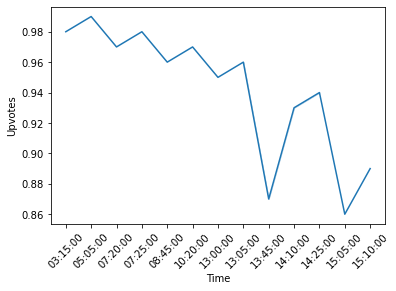

In [18]:
plotreddit(r26, 'Time', 'Upvotes')

In [19]:
dr26 = merged(df26, r26, 'Time')

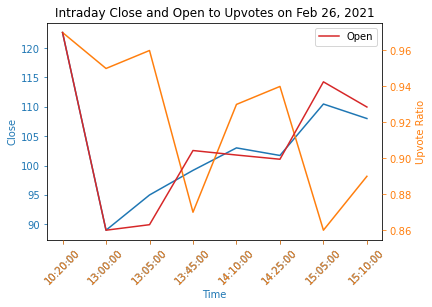

In [20]:
plotboth(dr26, 'Feb 26, 2021')

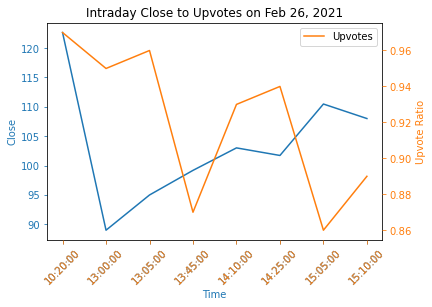

In [21]:
plotboth(dr26, 'Feb 26, 2021', False)

In [22]:
#find correlation between the trend of the upvotes and the intraday stock
dr26.Close.corr(dr26.Upvotes)

-0.0874447575656149

### march 1, 2021

In [23]:
df1 = specificIntraday(df, '2021-03-01')

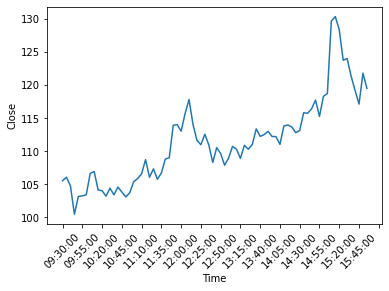

In [24]:
plotintraday(df1, 'Time', 'Close')

In [25]:
reddit1 = redditFile('RedditStocksDate3-1.csv')

In [26]:
r1 = redditDay(reddit1, 'gamestop', 'gme', '2021-03-01')

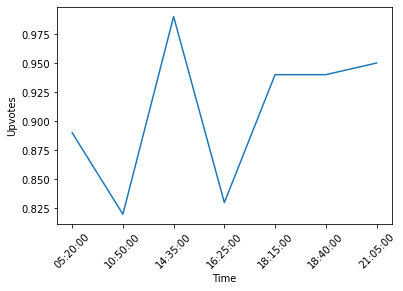

In [27]:
plotreddit(r1, 'Time', 'Upvotes')

In [28]:
dr1 = merged(df1, r1, 'Time')

In [29]:
dr1

,Open,High,Low,Close,Change,Volume,Date_x,Time,Upvotes,Stock,Count,Date_y
0,103.75,103.76,102.5000,103.0448,-0.7452,193466.0,2021-03-01,10:50:00,0.82,gme,1,2021-03-01
1,113.16,117.71,113.0801,115.7900,2.6900,845152.0,2021-03-01,14:35:00,0.99,gamestop,1,2021-03-01


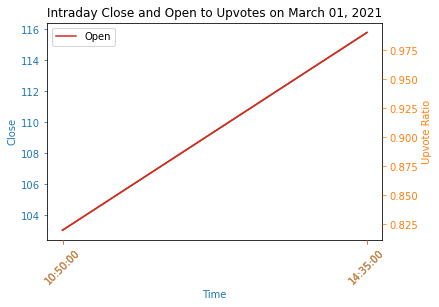

In [30]:
plotboth(dr1, 'March 01, 2021')

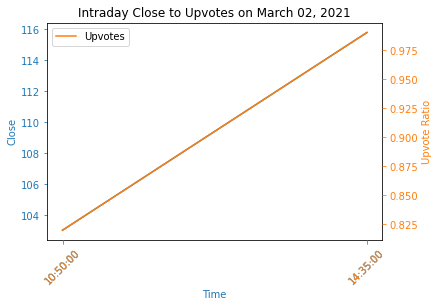

In [31]:
plotboth(dr1, 'March 02, 2021', False)

In [32]:
dr1.Close.corr(dr1.Upvotes)

0.9999999999999999

### march 2, 2021

In [33]:
df2 = specificIntraday(df, '2021-03-02')

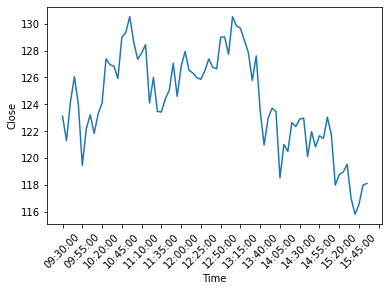

In [34]:
plotintraday(df2, 'Time', 'Close')

In [35]:
reddit2 = redditFile('RedditStocksDate3-2.csv')

In [36]:
r2 = redditDay(reddit2, 'gamestop', 'gme', '2021-03-02')

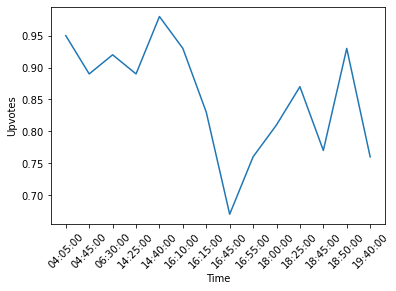

In [37]:
plotreddit(r2, 'Time', 'Upvotes')

In [38]:
dr2 = merged(df2, r2, 'Time')

In [39]:
dr2

,Open,High,Low,Close,Change,Volume,Date_x,Time,Upvotes,Stock,Count,Date_y
0,122.5273,122.7500,121.17,122.3362,-0.2938,124786.0,2021-03-02,14:25:00,0.89,gme,1,2021-03-02
1,122.7686,122.9899,120.08,120.1001,-2.8600,183766.0,2021-03-02,14:40:00,0.98,gme,1,2021-03-02
2,122.7686,122.9899,120.08,120.1001,-2.8600,183766.0,2021-03-02,14:40:00,0.98,gamestop,1,2021-03-02


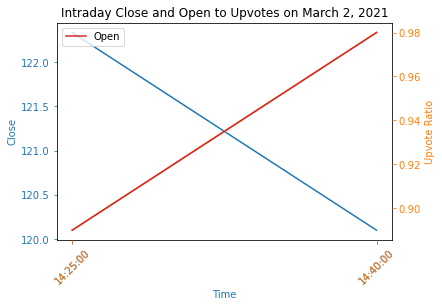

In [40]:
plotboth(dr2, 'March 2, 2021')

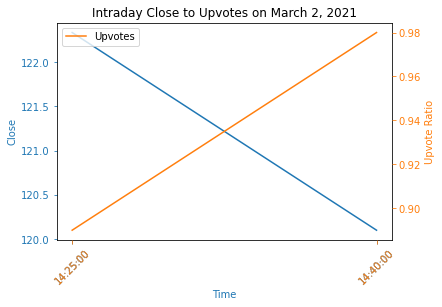

In [41]:
plotboth(dr2, 'March 2, 2021', False)

In [42]:
dr2.Close.corr(dr2.Upvotes)

-0.9999999999999999

### march 3, 2021

In [43]:
df3 = specificIntraday(df, '2021-03-03')

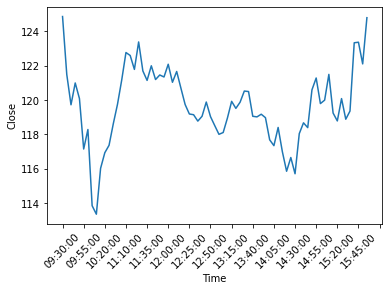

In [44]:
plotintraday(df3, 'Time', 'Close')

In [45]:
reddit3 = redditFile('RedditStocksDate3-3.csv')

In [46]:
r3 = redditDay(reddit3, 'gamestop', 'gme', '2021-03-03')

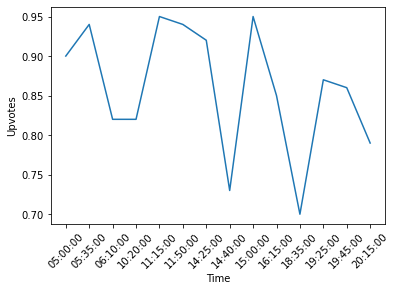

In [47]:
plotreddit(r3, 'Time', 'Upvotes')

In [48]:
dr3 = merged(df3, r3, 'Time')

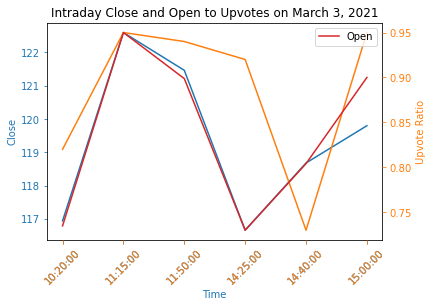

In [49]:
plotboth(dr3, 'March 3, 2021')

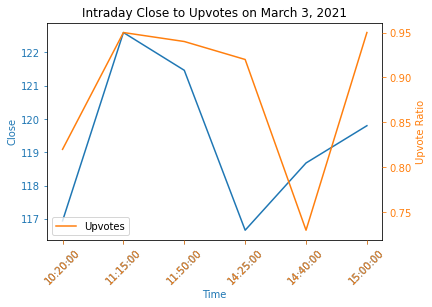

In [50]:
plotboth(dr3, 'March 3, 2021', False)

In [51]:
dr3.Close.corr(dr3.Upvotes)

0.41259083929583157

### march 4, 2021

In [54]:
df4 = specificIntraday(df, '2021-03-04')

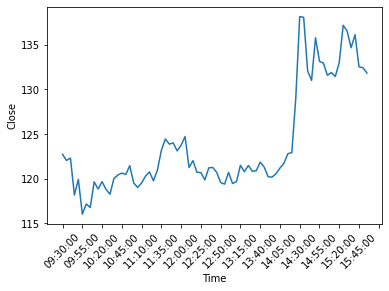

In [55]:
plotintraday(df4, 'Time', 'Close')

In [56]:
reddit4 = redditFile('RedditStocksDate3-4.csv')

In [57]:
r4 = redditDay(reddit4, 'gamestop', 'gme', '2021-03-04')

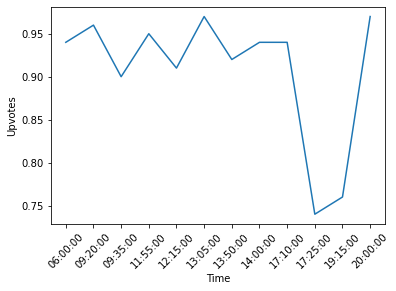

In [58]:
plotreddit(r4, 'Time', 'Upvotes')

In [59]:
dr4 = merged(df4, r4, 'Time')

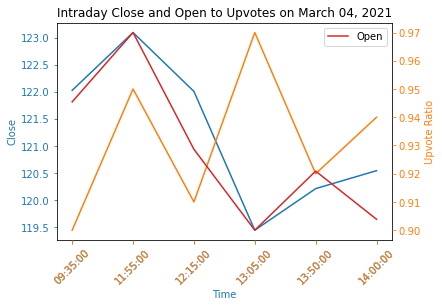

In [60]:
plotboth(dr4, 'March 04, 2021')

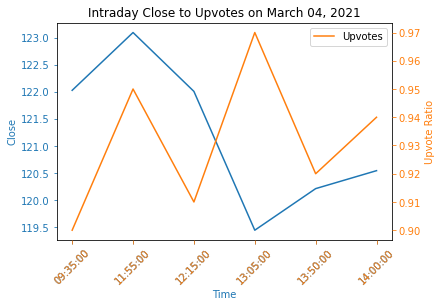

In [61]:
plotboth(dr4, 'March 04, 2021', False)

In [62]:
dr4.Close.corr(dr4.Upvotes)

-0.3124131779778566

### march 5, 2021

In [89]:
df5 = specificIntraday(df, '2021-03-05')

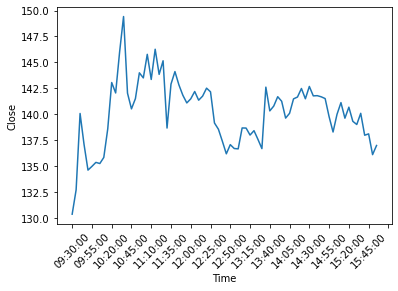

In [90]:
plotintraday(df5, 'Time', 'Close')

In [92]:
reddit5 = redditFile('RedditStocksDate3-5.csv')

In [93]:
r5 = redditDay(reddit5, 'gamestop','gme', '2021-03-05')

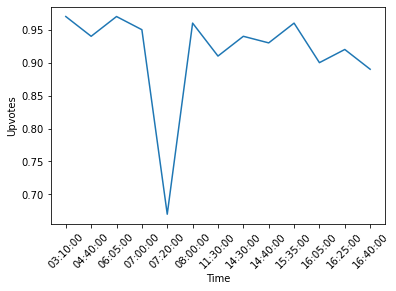

In [94]:
plotreddit(r5, 'Time', 'Upvotes')

In [95]:
dr5 = merged(df5, r5, 'Time')

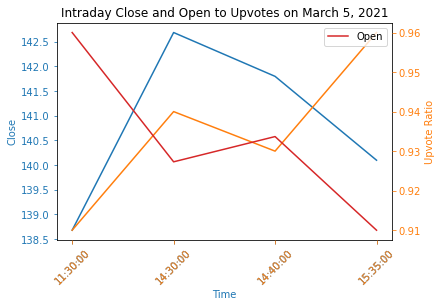

In [96]:
plotboth(dr5, 'March 5, 2021')

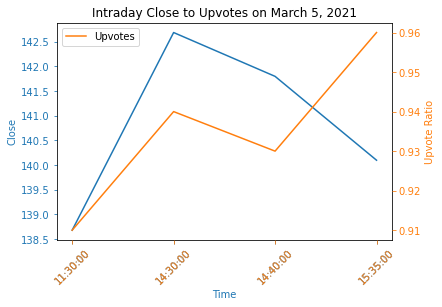

In [97]:
plotboth(dr5, 'March 5, 2021', False)

In [98]:
dr5.Close.corr(dr5.Upvotes)

0.3583215598130066